In [7]:
# !pip install pandas numpy nltk scikit-learn matplotlib seaborn


In [ ]:
import pandas as pd #импортируем pandas для работы с данными
import numpy as np #импортируем numpy для работы с массивами
import re #импортируем регулярные выражения
import nltk #импортируем nltk для обработки текста
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

from nltk.corpus import stopwords # Импортируем стоп-слова
from sklearn.model_selection import train_test_split, cross_val_score, KFold 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier # Для мульти-лейбл классификации
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, hamming_loss

import matplotlib.pyplot as plt
import seaborn as sns

print('Библиотеки успешно импортированы')

Библиотеки успешно импортированы


Загрузка обработанных данных

Данные были предварительно обработаны: удалены дубликаты, категории приведены к бинарному формату, добавлена категория "Ничего из перечисленного".


In [9]:
data_path = 'Test данные.csv'

try:
    df = pd.read_csv(data_path)
    print("Данные успешно загружены.")
    print(f"Размер датасета: {df.shape}")
    print("Первые 5 строк:")
    print(df.head())
    print("Информация о датасете:")
    df.info()
except FileNotFoundError:
    print(f"Файл не найден по пути: {data_path}. Убедитесь, что путь указан верно.")

Данные успешно загружены.
Размер датасета: (2373, 9)
Первые 5 строк:
                                          categories  \
0                                       Вопрос решен   
1  {"choices":["Понравилось выполнение заявки","В...   
2  {"choices":["Понравилось выполнение заявки","В...   
3  {"choices":["Нравится скорость отработки заяво...   
4  {"choices":["Нравится качество работы сотрудни...   

                                        comment       id  rating  \
0                                       спасибо  2945792       5   
1                                      спасибо!  3234340       5   
2                                      Отлично   3380332       5   
3  Благодарю за оперативное решение проблемы !   3381812       5   
4         Прекрасный специалист! Побольше таких  3461991       5   

   Вопрос решен  Нравится качество выполнения заявки  \
0             1                                    0   
1             1                                    0   
2             1  

Категория Ничего из перечисленного была исключена, так как содержит только один класс или отсутствует в данных.
Используемые категории для обучения и оценки: ['Вопрос решен', 'Нравится качество выполнения заявки', 'Нравится качество работы сотрудников', 'Нравится скорость отработки заявок', 'Понравилось выполнение заявки']


C:\Users\Darin_btw\AppData\Local\Temp\ipykernel_24600\1591468989.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")


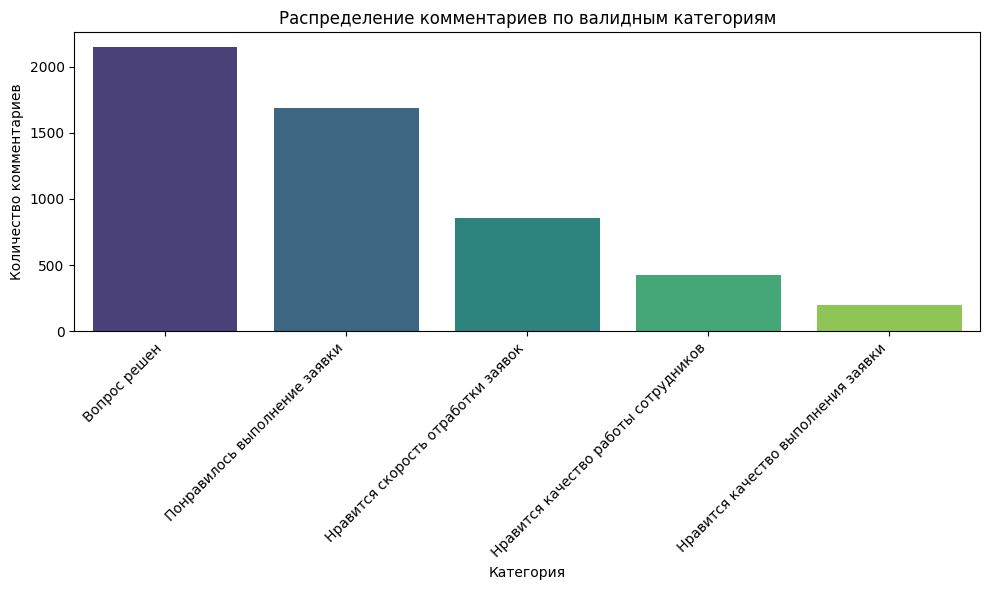

Распределение по валидным категориям:
Вопрос решен                            2152
Понравилось выполнение заявки           1691
Нравится скорость отработки заявок       859
Нравится качество работы сотрудников     425
Нравится качество выполнения заявки      202
dtype: int64


In [10]:
initial_category_cols = [
    'Вопрос решен',
    'Нравится качество выполнения заявки',
    'Нравится качество работы сотрудников',
    'Нравится скорость отработки заявок',
    'Понравилось выполнение заявки',
    'Ничего из перечисленного'
 ]

# Фильтрация категорий, имеющих более одного уникального значения (т.е. не только 0 или только 1)
valid_category_cols = []
for col in initial_category_cols:
    if col in df.columns and df[col].nunique() > 1:
        valid_category_cols.append(col)
    else:
        print(f"Категория {col} была исключена, так как содержит только один класс или отсутствует в данных.")

if not valid_category_cols:
    raise ValueError("Нет валидных категорий для обучения после фильтрации. Проверьте данные.")

print(f"Используемые категории для обучения и оценки: {valid_category_cols}")

# Подсчет количества комментариев по валидным категориям
category_counts = df[valid_category_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.title('Распределение комментариев по валидным категориям')
plt.xlabel('Категория')
plt.ylabel('Количество комментариев')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Распределение по валидным категориям:")
print(category_counts)


Предобработка текста комментариев


In [11]:
stop_words_russian = stopwords.words('russian')
# russian_stemmer = SnowballStemmer('russian') # Опционально для стемминга

def preprocess_text(text):
    text = str(text).lower()  # Приведение к нижнему регистру
    text = re.sub(r'\s+[а-я]{1,2}\s+', ' ', text) # Удаление коротких предлогов/союзов (очень грубо)
    text = re.sub(r'[^а-яА-ЯёЁ0-9\s]', ' ', text)  # Удаление пунктуации и спецсимволов, оставляем только кириллицу, цифры и пробелы
    text = re.sub(r'\s+', ' ', text).strip()  # Удаление лишних пробелов
    tokens = text.split() # Замена word_tokenize для русского языка
    tokens = [word for word in tokens if word not in stop_words_russian and len(word) > 2] # Удаление стоп-слов и коротких слов
    # tokens = [russian_stemmer.stem(word) for word in tokens] # Опциональный стемминг
    
    return ' '.join(tokens)

# Применение предобработки к столбцу 'comment'
# Убедимся, что столбец 'comment' существует и не пустой
if 'comment' in df.columns:
    df['processed_comment'] = df['comment'].apply(preprocess_text)
    print("Пример обработанного комментария:")
    if not df.empty and 'comment' in df and 'processed_comment' in df:
        print(f"Оригинал: {df['comment'].iloc[0]}")
        print(f"Обработанный: {df['processed_comment'].iloc[0]}")
        print("Первые 5 строк с обработанными комментариями:")
        print(df[['comment', 'processed_comment']].head())
    else:
        print("DataFrame пуст или отсутствуют необходимые столбцы для вывода примера.")
else:
    print("Столбец 'comment' не найден в DataFrame.")


Пример обработанного комментария:
Оригинал: спасибо
Обработанный: спасибо
Первые 5 строк с обработанными комментариями:
                                        comment  \
0                                       спасибо   
1                                      спасибо!   
2                                      Отлично    
3  Благодарю за оперативное решение проблемы !    
4         Прекрасный специалист! Побольше таких   

                        processed_comment  
0                                 спасибо  
1                                 спасибо  
2                                 отлично  
3  благодарю оперативное решение проблемы  
4    прекрасный специалист побольше таких  
